In [43]:
from gensim.models import word2vec
from rdkit import Chem
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
import pandas as pd
import numpy as np
import pickle
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import time
import argparse
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.init as init
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import wandb
from tqdm import tqdm


device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

mol2vec_model = word2vec.Word2Vec.load('mol2vec/model_300dim.pkl')


Using cuda device


In [44]:
smiles = 'CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1'
mol = Chem.MolFromSmiles(smiles)
sentence = mol2alt_sentence(mol, 1)
mol_sentence = MolSentence(sentence)
embedding = sentences2vec(mol_sentence, mol2vec_model, unseen='UNK')
embedding_array = DfVec(embedding).vec
embedding_array

array([[ 1.2513949,  2.334477 , -1.2833012, ..., -3.1253083, -1.1473327,
         1.8111763],
       [ 1.2513949,  2.334477 , -1.2833012, ..., -3.1253083, -1.1473327,
         1.8111763],
       [ 1.2513949,  2.334477 , -1.2833012, ..., -3.1253083, -1.1473327,
         1.8111763],
       ...,
       [ 1.2513949,  2.334477 , -1.2833012, ..., -3.1253083, -1.1473327,
         1.8111763],
       [ 1.2513949,  2.334477 , -1.2833012, ..., -3.1253083, -1.1473327,
         1.8111763],
       [ 1.1262554,  2.1010292, -1.1549711, ..., -2.8127775, -1.0325994,
         1.6300586]], dtype=float32)

In [45]:
df = pd.read_csv('../baselines/RNN/datasets/Dataset 1.csv') #to be comparable with the size of other datasets, select ~5000 data points from the reference

#df = df.head(1000)
df['TRIMER_mol'] = df['TRIMER'].apply(Chem.MolFromSmiles)
df['TRIMER_sen'] = df['TRIMER_mol'].apply(lambda mol: mol2alt_sentence(mol, 1))
# Generate embedding_array for each sentence
df['embedding_array'] = df['TRIMER_sen'].apply(lambda mol_sentence: sentences2vec(mol_sentence, mol2vec_model, unseen='UNK'))

# Convert embedding_array to NumPy array
df['embedding_array'] = df['embedding_array'].apply(lambda embedding: DfVec(embedding).vec)
df = df.dropna()


In [46]:
embedding_shape = df['embedding_array'].iloc[0].shape

print(f"The dimensions of the embedding_array are: {embedding_shape}")


The dimensions of the embedding_array are: (56, 300)


In [47]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

#reset index
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

In [48]:
class TrimerMol2VecDataset(Dataset):
    def __init__(self, data, target_column, pad_length):
        self.data = data
        self.target_column = target_column
        self.pad_length = pad_length

    def __getitem__(self, index):
        tokens = self.data.loc[index, "embedding_array"]
        target = self.data.loc[index, self.target_column]
        
        # Flatten the tokens
        tokens = tokens.reshape(-1)
        
        # Pad the tokens, padding at the end
        tokens_padded = np.pad(tokens, (0, self.pad_length - len(tokens)), mode='constant')

        tokens_tensor = torch.tensor(tokens_padded, dtype=torch.float32)
        target_tensor = torch.tensor(target, dtype=torch.float32)

        return tokens_tensor, target_tensor

    def __len__(self):
        return len(self.data)


In [49]:
target_column = "EA (eV)"
# Find the maximum length of the embedding arrays
max_length = df['embedding_array'].apply(lambda x: x.size).max()

train_dataset = TrimerMol2VecDataset(train_data, target_column, max_length)
test_dataset = TrimerMol2VecDataset(test_data, target_column, max_length)
val_dataset = TrimerMol2VecDataset(val_data, target_column, max_length)

In [50]:
batch_size = 32
shuffle = True
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)

In [51]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3):
        super(MLP, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.layers = nn.ModuleList()

        # First hidden layer
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        init.xavier_uniform_(self.layers[-1].weight)
        init.zeros_(self.layers[-1].bias)

        # Additional hidden layers
        for i in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            init.xavier_uniform_(self.layers[-1].weight)
            init.zeros_(self.layers[-1].bias)

        # Output layer
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        init.xavier_uniform_(self.layers[-1].weight)
        init.zeros_(self.layers[-1].bias)

    def forward(self, x):
        for i in range(self.num_layers - 1):
            x = nn.functional.relu(self.layers[i](x))
        x = self.layers[-1](x)
        return x

    def __str__(self):
        layer_str = '\n'.join([f'Layer {i}: {layer}' for i, layer in enumerate(self.layers)])
        return f'MLP Model:\n{layer_str}'


In [52]:
input_dim = max_length
hidden_dim = 100
num_layers = 3

output_dim = 1
num_tokens=1024
learning_rate = 0.001

model = MLP(input_dim, hidden_dim, output_dim, num_layers=3).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [53]:
def train_MLP(model, train_loader, test_loader, loss_fn, optimizer, num_epochs=10, device="cpu"):
    model.to(device)
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for x, y in train_loader:
            #x, y = x.to(device), y.to(device)
            x = x.to(device).float()
            y = y.to(device).float()
            y = y.view(-1, 1)

            optimizer.zero_grad()
            output = model(x)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Testing
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x, y in test_loader:
                #x, y = x.to(device), y.to(device)
                x = x.to(device).float()
                y = y.to(device).float()
                y = y.view(-1, 1)

                output = model(x)
                loss = loss_fn(output, y)
                test_loss += loss.item()

        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    return train_losses, test_losses

In [54]:
num_epochs = 5
train_losses, test_losses = train_MLP(model, train_dataloader, val_dataloader, loss_fn, optimizer, num_epochs, device)

Epoch 1/5, Train Loss: 1.5045, Test Loss: 0.5779
Epoch 2/5, Train Loss: 1.7829, Test Loss: 0.4828
Epoch 3/5, Train Loss: 0.4548, Test Loss: 0.4005
Epoch 4/5, Train Loss: 0.4178, Test Loss: 0.4521
Epoch 5/5, Train Loss: 0.4245, Test Loss: 0.4385


In [55]:
current_time = time.strftime("%Y%m%d-%H%M%S")
model_path = f"model_mol2vec_mlp{current_time}.pt"

torch.save(model.state_dict(), model_path)
print("Saved PyTorch Model State to "+model_path)

Saved PyTorch Model State to model_mol2vec_mlp20230419-080340.pt


In [56]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(model, dataloader, device):
    model.eval()
    all_outputs = []
    all_targets = []
    
    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            x = x.to(device).float()
            y = y.to(device).float()
            y = y.view(-1, 1)
            
            output = model(x)
            all_outputs.extend(output.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    return np.array(all_outputs), np.array(all_targets)

# Evaluate the model
predicted, targets = evaluate_model(model, test_dataloader, device)

# Calculate R2 score, MAE, and RMSE
r2 = r2_score(targets, predicted)
mae = mean_absolute_error(targets, predicted)
rmse = np.sqrt(mean_squared_error(targets, predicted))

print(f"R2 Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

R2 Score: -0.0141
Mean Absolute Error: 0.5450
Root Mean Squared Error: 0.6633


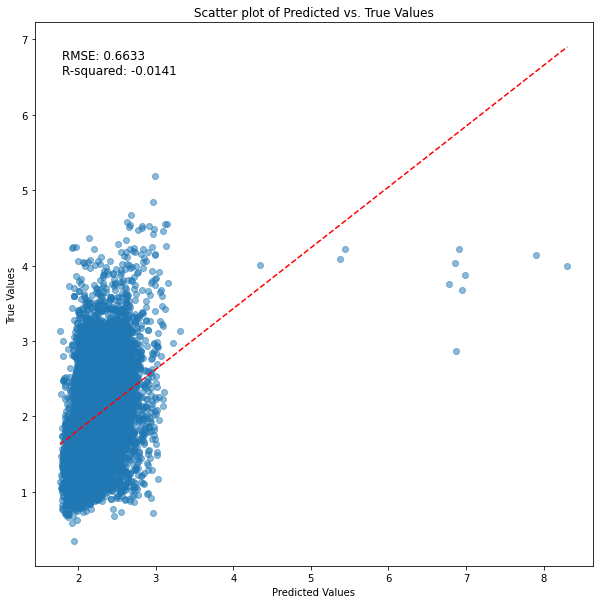

In [57]:
targets_np = np.array(targets).flatten()
predicted_np = np.array(predicted).flatten()

plt.figure(figsize=(10, 10))
plt.scatter(predicted_np, targets_np, alpha=0.5)

# Fit a linear regression model
m, b = np.polyfit(predicted_np, targets_np, 1)

# Create line points based on the min and max of the predicted values
line_x = np.linspace(min(predicted_np), max(predicted_np), 100)
line_y = m * line_x + b

# Plot the best fit line
plt.plot(line_x, line_y, '--', c='r')
plt.text(0.05, 0.95, f'RMSE: {rmse:.4f}\nR-squared: {r2:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter plot of Predicted vs. True Values')
plt.show()
